In [1]:
import numpy as np
import ProGED as pg
import matplotlib.pyplot as plt
import os
import sys
from ProGED.examples.DS2022.generate_data_ODE_systems import generate_ODE_data, lorenz

In [2]:
    np.random.seed(0)

    inits = [1,1,1]
    rho = 16
    lor = lambda t, x: lorenz(t, x, rho=rho)
    data = generate_ODE_data(lor, inits)
    T = data[:,0]
    deltaT = T[1]-T[0]
    X = data[:, 1:]
    dX = np.array([np.gradient(Xi, deltaT) for Xi in X.T])

In [3]:
folder = "E:/Dropbox/github/PCFGproject/ProGED/examples/DS2022/results/numdiff/"
file = "numdiff_lorenz_custom"

In [40]:
models = [pg.ModelBox() for i in range(3)]
meantimes = []
for i in range(3):
    models[i].load(folder + file + "_eq" + str(i) + "_models_fit.pg")
    times = [m.get_time() for m in models[i]]
    meantimes += [np.mean(times)]

In [5]:
for i in range(3):
    print("----", i, "----")
    print(models[i].retrieve_best_models(5))

---- 0 ----
ModelBox: 5 models
-> -9.98633805653992*x + 9.98632707691073*y - 0.000175691646940828, p = 2.719041454079999e-15, parse trees = 1, valid = True, error = 0.00019140908467392106, time = 18.646596908569336
-> -9.98633985383915*x + 9.98632871007659*y - 0.000176525126530509, p = 2.564352e-07, parse trees = 2, valid = True, error = 0.00019140908597363478, time = 8.398370742797852
-> -9.98633915787251*x + 9.98632667060028*y - 0.000185275975129266, p = 1.0838015999999997e-11, parse trees = 1, valid = True, error = 0.00019140909027406697, time = 15.809401035308838
-> -9.98634324933474*x + 9.98632986198233*y - 0.000188509896068443, p = 2.7095039999999995e-08, parse trees = 1, valid = True, error = 0.0001914091075817723, time = 18.868375778198242
-> -9.98632984010035*x + 9.98632984010035*y - 0.000110376994044259, p = 8.495062371532796e-16, parse trees = 1, valid = True, error = 0.00019140949002443858, time = 12.174851894378662
---- 1 ----
ModelBox: 5 models
-> -0.99727904451327*x*z + 

In [20]:
succprob = []
for i in range(3):
    dat = np.hstack((dX[i].reshape((-1,1)), X))
    SRi, curvesx = pg.postprocessing.resample_curve(models[i], dat, target_variable_index=0, success_threshold=1e-1, resampleN=1000)
    succprob += [SRi/1000]


317
762
399


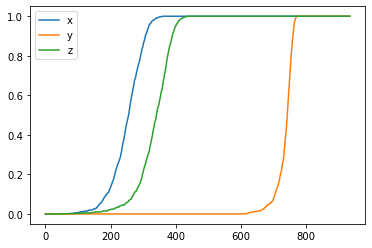

In [41]:
n95 = []
for i in range(3):
    plt.plot(succprob[i], label=["x","y","z"][i])
    n95 += [np.where(succprob[i]>0.95)[0][0]]
    print(n95[-1])
plt.legend()

x - 0.95% success probability:  317 models, 11 minutes
y - 0.95% success probability:  762 models, 25 minutes
z - 0.95% success probability:  399 models, 14 minutes


Text(0.5, 1.0, 'ProGED: numeric derivatives, alternative grammar')

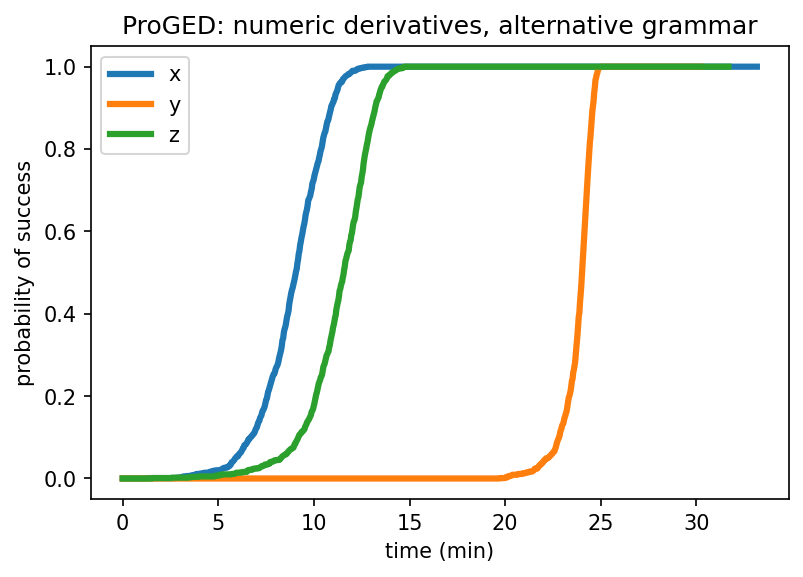

In [59]:
plt.figure(dpi=150)
for i in range(3):
    t = np.array(list(range(len(succprob[0]))))*meantimes[i]/60
    plt.plot(t, succprob[i], label=["x","y","z"][i], lw=3)
    print(["x","y","z"][i], "- 95% success probability: ", n95[i], "models,", round(meantimes[i]*n95[i]/60), "minutes")
plt.legend()
plt.xlabel("time (min)")
plt.ylabel("probability of success")
plt.title("ProGED: numeric derivatives, alternative grammar")